%TODO
* ~~add vocab_size feature to data_reader & vocab~~
* ~~properly handle first and last messages in dialogs (they have only one target)~~
* ~~next_seq decoder~~
* ~~prev_seq decoder~~
* ~~loss~~
* ~~train op~~
* ~~training+verbosing~~
* many layers option
* bidirectional option
* saving/restoring model

In [1]:
import data_reader
import utils
import tensorflow as tf
import math
import numpy as np
import time

## Define tensorflow FLAGS.

In [2]:
FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_integer('num_epochs', 100, "Number of epochs.")
tf.app.flags.DEFINE_integer('batch_size', 64, "The size of batch.")
tf.app.flags.DEFINE_integer('num_hidden', 512, 'Hidden size of GRU cell.')
tf.app.flags.DEFINE_integer('embedding_size', 128, 'The size of word embeddings.')
tf.app.flags.DEFINE_integer('max_vocab_size', 110, 'Size of vocabulary. Most frequent words are used.')
tf.app.flags.DEFINE_integer('bottleneck_size', 128, 'Size of bottleneck softmax. It avoids matrices from num_hidden to vocab_size.')
tf.app.flags.DEFINE_float('learning_rate', 0.02, "Initial learning rate.")
tf.app.flags.DEFINE_float('decay_rate', 1.0, "Exponential decay rate.")
tf.app.flags.DEFINE_float('grad_clip', 5.0, "Value for gradient clipping.")

## Data processing. 
We read sequence data and generate `(prev, curr, next)` triples with sentences. They will be batched and passed to network.

In [3]:
dr = data_reader.SequenceDataReader('data/chats1000.txt', max_vocab_size=FLAGS.max_vocab_size)

# PAD_TOKEN_IDX = dr.vocab.encode_word(dr.vocab.PAD_TOKEN)
# EOS_TOKEN_IDX = dr.vocab.encode_word(dr.vocab.EOS_TOKEN)
# MAX_LENGTH = dr.max_len
PAD_TOKEN_IDX = 0
EOS_TOKEN_IDX = 1
MAX_LENGTH = 10

In [4]:
def get_curr_prev_next_triples(origin_X):
    line_lengths = map(len, origin_X)
    empty_line_indices = list(map(lambda x: x[0], filter(lambda x: x[1] <= 1, enumerate(line_lengths))))
    empty_line_indices = [-1]+empty_line_indices+[len(origin_X)]
    triples = [] # (curr, prev, next)
    for i in range(1, len(empty_line_indices)-1):
        from_idx = empty_line_indices[i-1]+1
        to_idx = empty_line_indices[i]
        for k in range(from_idx+1, to_idx-1):
            triples.append((origin_X[k], origin_X[k-1], origin_X[k+1]))
    return list(zip(*triples)) # three lists with equal lengths, corresponding to curr, prev and next sentences.

## Define placeholders and function for filling feed dictionary.

Because all `*_decoder` functions in `tf.nn.seq2seq` take lists as inputs, we can't do the same thing for supporting variable-length sequences as we do for encoder (`input_placeholder`).

To manage this problem, we could use bucketing (`tf.nn.seq2seq.model_with_buckets`) or just calculate maximum length of line in dataset and create such number of placeholders for decoder. 

`SequenceDataReader` has `max_length` property for that.

In [5]:
# 2. Encoder input
input_placeholder = tf.placeholder(tf.int32, shape=[None,None], name='enc_inputs')
sequence_length_placeholder = tf.placeholder(tf.int32, shape=[None,], name='seq_lengths')


# 3. Correct next output sequence for next_seq decoder.
next_seq_output_placeholder = [tf.placeholder(tf.int32, shape=[None,],
                                              name='dec_next_seq_output{0}'.format(i)) for i in range(MAX_LENGTH)]


# 4. Input for next_seq decoder. It contains last token in inputs (which is always <eos> token) and shifted decoder outputs.
next_seq_input_placeholder = [tf.ones_like(next_seq_output_placeholder[0])*EOS_TOKEN_IDX] + next_seq_output_placeholder[1:]



# 5. Correct previous output sequence for prev_seq decoder.
prev_seq_output_placeholder = [tf.placeholder(tf.int32, shape=[None,],
                                              name='dec_prev_seq_output{0}'.format(i)) for i in range(MAX_LENGTH)]


# 6. Input for prev_seq decoder.
prev_seq_input_placeholder = [tf.ones_like(prev_seq_output_placeholder[0])*EOS_TOKEN_IDX] + prev_seq_output_placeholder[1:]



# 7. Seq loss weights
prev_seq_loss_weights = [tf.placeholder(tf.float32, shape=[None,], name="prev_weight{0}".format(i)) for i in range(MAX_LENGTH)]
next_seq_loss_weights = [tf.placeholder(tf.float32, shape=[None,], name="next_weight{0}".format(i)) for i in range(MAX_LENGTH)]

def fill_feed_dict(curr_input, prev_output, next_output):
    feed_dict = {
        input_placeholder: curr_input,
        sequence_length_placeholder: utils.padded_sequence_lengths(curr_input, pad_value=PAD_TOKEN_IDX),
    }
    feed_dict.update({next_seq_output_placeholder[i]: next_output[:,i] for i in range(next_output.shape[1])})
    feed_dict.update({prev_seq_output_placeholder[i]: prev_output[:,i] for i in range(prev_output.shape[1])})
    
    prev_weights = utils.get_weights_for_sequence_loss(prev_output, PAD_TOKEN_IDX)
    next_weights = utils.get_weights_for_sequence_loss(next_output, PAD_TOKEN_IDX)
    feed_dict.update({prev_seq_loss_weights[i]: prev_weights[i] for i in range(len(prev_weights))})
    feed_dict.update({next_seq_loss_weights[i]: next_weights[i] for i in range(len(next_weights))})
    return feed_dict

## Define matrix for word embeddings.
* Tensor `embedded` is used as `inputs` in encoder network.

In [6]:
with tf.variable_scope('embeddings'):
    # Default initializer for embeddings should have variance=1.
    sqrt3 = math.sqrt(3)  # Uniform(-sqrt(3), sqrt(3)) has variance=1.
    initializer = tf.random_uniform_initializer(-sqrt3, sqrt3)
    embedding_matrix = tf.get_variable("embedding_matrix", shape=[FLAGS.max_vocab_size, FLAGS.embedding_size], initializer=initializer)

embedded = tf.nn.embedding_lookup(embedding_matrix, input_placeholder)

## Define encoder rnn.
* Tensor `encoder_state` will be used as initial state in decoder network.

In [7]:
with tf.variable_scope('encoder'):
    cell = tf.nn.rnn_cell.GRUCell(FLAGS.num_hidden)
    _, encoder_state = tf.nn.dynamic_rnn(cell,
                                         dtype=tf.float32,
                                         inputs=embedded,
                                         sequence_length=sequence_length_placeholder)

## Define two decoders. One for decoding previous sentence, and second for next sequence.

* Instead of using `OutputProjectionWrapper` we could initialize output projection explicitly and pass it to `tf.nn.seq2seq._extract_argmax_and_embed`.


* Also, we can't use `EmbeddingWrapper` because we want to share embeddings between encoder and decoders.


* **NOTE** that we actually create two output variables for each decoder. One for training (without feeding previous output from decoder to the next input) and the second one for predicting. So, `next/prev_seq_outputs_predict` will not be used while training the model. They are only needed for predicting sequences when model is trained.

### Define next sequence decoder.

In [8]:
loop_function_train = tf.nn.seq2seq._extract_argmax_and_embed(embedding_matrix, update_embedding=True)
# loop_function_predict = tf.nn.seq2seq._extract_argmax_and_embed(embedding_matrix, update_embedding=False)

with tf.variable_scope("next_seq_decoder"):
    embedded_next_seq_inputs = [tf.nn.embedding_lookup(embedding_matrix, inp) for inp in next_seq_input_placeholder]
    
    cell = tf.nn.rnn_cell.GRUCell(FLAGS.num_hidden)
    cell = tf.nn.rnn_cell.OutputProjectionWrapper(cell, FLAGS.max_vocab_size)
    
    next_seq_outputs_train, _ = tf.nn.seq2seq.rnn_decoder(embedded_next_seq_inputs, initial_state=encoder_state,
                                                          cell=cell, loop_function=loop_function_train)
# with tf.variable_scope("next_seq_decoder", reuse=True):
#     next_seq_outputs_predict, _ = tf.nn.seq2seq.rnn_decoder(embedded_next_seq_inputs, initial_state=encoder_state,
#                                                            cell=cell, loop_function=loop_function_predict)

### The same thing with prev sequence decoder.

In [9]:
with tf.variable_scope("prev_seq_decoder"):
    embedded_prev_seq_inputs = [tf.nn.embedding_lookup(embedding_matrix, inp) for inp in prev_seq_input_placeholder]
    
    cell = tf.nn.rnn_cell.GRUCell(FLAGS.num_hidden)
    cell = tf.nn.rnn_cell.OutputProjectionWrapper(cell, FLAGS.max_vocab_size)
    
    prev_seq_outputs_train, _ = tf.nn.seq2seq.rnn_decoder(embedded_prev_seq_inputs, initial_state=encoder_state,
                                                          cell=cell, loop_function=loop_function_train)
# with tf.variable_scope("prev_seq_decoder", reuse=True):
#     prev_seq_outputs_predict, _ = tf.nn.seq2seq.rnn_decoder(embedded_prev_seq_inputs, initial_state=encoder_state,
#                                                            cell=cell, loop_function=loop_function_predict)

### Now, we can define loss and train_op for our network.

In [31]:
loss_prev = tf.nn.seq2seq.sequence_loss(prev_seq_outputs_train,
                                        prev_seq_output_placeholder,
                                        prev_seq_loss_weights)
loss_next = tf.nn.seq2seq.sequence_loss(next_seq_outputs_train,
                                        next_seq_output_placeholder,
                                        next_seq_loss_weights)

# Final loss.
loss = loss_prev + loss_next

# Optimizer with decaying learning rate.
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(FLAGS.learning_rate,
                                           global_step,
                                           len(dr.get_data()),
                                           FLAGS.decay_rate,
                                           staircase=True)
opt = tf.train.AdamOptimizer(learning_rate)

# Perform gradient clipping.
tvars = tf.trainable_variables()
grads = tf.gradients(loss, tvars)
clipped_grads, norm = tf.clip_by_global_norm(tvars, FLAGS.grad_clip)

train_op = opt.apply_gradients(zip(clipped_grads, tvars), global_step=global_step)

### Let's look at the parameters in our network.

In [32]:
for x in tvars:
    print(x.name)

embeddings/embedding_matrix:0
encoder/RNN/GRUCell/Gates/Linear/Matrix:0
encoder/RNN/GRUCell/Gates/Linear/Bias:0
encoder/RNN/GRUCell/Candidate/Linear/Matrix:0
encoder/RNN/GRUCell/Candidate/Linear/Bias:0
next_seq_decoder/rnn_decoder/GRUCell/Gates/Linear/Matrix:0
next_seq_decoder/rnn_decoder/GRUCell/Gates/Linear/Bias:0
next_seq_decoder/rnn_decoder/GRUCell/Candidate/Linear/Matrix:0
next_seq_decoder/rnn_decoder/GRUCell/Candidate/Linear/Bias:0
next_seq_decoder/rnn_decoder/OutputProjectionWrapper/Linear/Matrix:0
next_seq_decoder/rnn_decoder/OutputProjectionWrapper/Linear/Bias:0
prev_seq_decoder/rnn_decoder/GRUCell/Gates/Linear/Matrix:0
prev_seq_decoder/rnn_decoder/GRUCell/Gates/Linear/Bias:0
prev_seq_decoder/rnn_decoder/GRUCell/Candidate/Linear/Matrix:0
prev_seq_decoder/rnn_decoder/GRUCell/Candidate/Linear/Bias:0
prev_seq_decoder/rnn_decoder/OutputProjectionWrapper/Linear/Matrix:0
prev_seq_decoder/rnn_decoder/OutputProjectionWrapper/Linear/Bias:0


### Define training procedure.

In [33]:
EOS_TOKEN_IDX, PAD_TOKEN_IDX

(1, 0)

In [34]:
norms = []
def train(sess, verbose=1000):
#     curr_data, prev_data, next_data = get_curr_prev_next_triples(dr.get_data())
    curr_data = [list(np.random.randint(1, 15, size=10))+[EOS_TOKEN_IDX]]*1000
    prev_data = [x[::2]+[EOS_TOKEN_IDX] for x in curr_data]
    next_data = [x[1::2]+[EOS_TOKEN_IDX] for x in curr_data]
    for e in range(FLAGS.num_epochs):
        it = utils.seq2seq_triples_data_iterator(curr_data, prev_data, next_data, 10,
                                                 batch_size=FLAGS.batch_size, shuffle=True, pad_value=PAD_TOKEN_IDX)
        num_batches = int(np.ceil(len(curr_data)) / float(FLAGS.batch_size))
        for b, (curr_batch, prev_batch, next_batch) in enumerate(it):
            start_time = time.time()
            feed_dict = fill_feed_dict(curr_batch, prev_batch, next_batch)
            batch_loss, grad_norm, _ = sess.run([loss, norm, train_op], feed_dict=feed_dict)
            norms.append(grad_norm)
            batch_perplexity = math.exp(float(batch_loss)) if batch_loss < 300 else float("inf")
            end_time = time.time()
            if b % verbose == 0:
                    print(
                        "{}/{} (epoch {}), train_loss = {:.3f}, perplexity = {:.3f}, time/batch = {:.3f}" \
                        .format(e * num_batches + b,
                                FLAGS.num_epochs * num_batches,
                                e, batch_loss, batch_perplexity, end_time - start_time))

In [35]:
with tf.Session() as sess:
    init = tf.initialize_all_variables()
    sess.run(init)
    train(sess, verbose=10)

0/1500 (epoch 0), train_loss = 9.320, perplexity = 11164.237, time/batch = 0.276
10/1500 (epoch 0), train_loss = 9.393, perplexity = 12007.900, time/batch = 0.189
15/1500 (epoch 1), train_loss = 9.401, perplexity = 12096.172, time/batch = 0.170
25/1500 (epoch 1), train_loss = 9.400, perplexity = 12083.535, time/batch = 0.169
30/1500 (epoch 2), train_loss = 9.401, perplexity = 12095.999, time/batch = 0.180
40/1500 (epoch 2), train_loss = 9.401, perplexity = 12100.187, time/batch = 0.170
45/1500 (epoch 3), train_loss = 9.401, perplexity = 12100.660, time/batch = 0.174
55/1500 (epoch 3), train_loss = 9.401, perplexity = 12100.118, time/batch = 0.183
60/1500 (epoch 4), train_loss = 9.401, perplexity = 12100.002, time/batch = 0.198
70/1500 (epoch 4), train_loss = 9.401, perplexity = 12100.129, time/batch = 0.179
75/1500 (epoch 5), train_loss = 9.401, perplexity = 12099.968, time/batch = 0.170
85/1500 (epoch 5), train_loss = 9.401, perplexity = 12100.014, time/batch = 0.165
90/1500 (epoch 6)

KeyboardInterrupt: 

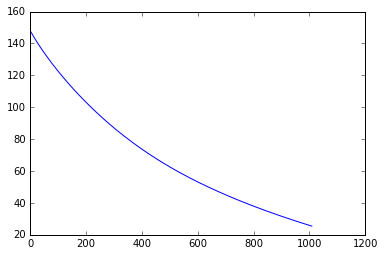

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(norms)